# Hourly demand

The default method for constructing hourly demand data in PowerGenome starts with state-level hourly profiles by economic sector released from NREL's Electrification Futures Study. When combined with scenarios of electrified technology stocks, future hourly demand is calculated using a combined bottom-up and top-down method.
1. Subtract existing hourly demand from electrified technologies such as building heating/cooling, water heating, and electric vehicles.
2. Multiply the remaining hourly demand by sector-specific (residential, commercial, industrial, and transportation) growth rates calculated from EIA AEO scenarios.
3. Add the future demand of electrified technologies using the stock values from of the available scenarios and their hourly demand profiles.

Steps 1. and 3. will be skipped if the parameters `electrification_stock_fn` and `electrification_scenario` are not included in the settings.

## Flexible demand resources

GenX can use some of the electrified technology demand as a flexible resource, shifing the load in time. This is controlled with the `flexible_demand_resources` parameter. **The electrified technologies are included in hourly demand even if they are not listed in this parameter.**

The type of flexible loads that can be included as flexible demand resources (with hourly profiles from NREL EFS data) are:

- `res_space_heat_cool` (residential space heating and cooling)
- `res_water_heat` (residential water heating)
- `comm_space_heat_cool` (commercial space heating and cooling)
- `comm_water_heat` (commercial water heating)
- `trans_light_duty` (light duty vehicles)
- `trans_medium_duty` (medium duty vehicles)
- `trans_heavy_duty` (heavy duty vehicles)
- `trans_bus` (transit buses)

The ISONE example system uses just two of these. 

```yaml
flexible_demand_resources:
  2030:
    trans_light_duty:
      fraction_shiftable: 0.8
      parameter_values:
        Max_Flexible_Demand_Delay: 5
        FLEX: 1
        Flexible_Demand_Energy_Eff: 1
    res_water_heat:
      fraction_shiftable: 0.1
      parameter_values:
        Max_Flexible_Demand_Delay: 2
        FLEX: 1
        Flexible_Demand_Energy_Eff: 1
```


## Distributed generation

Distributed generation in the form of rooftop solar is difficult to include in capacity expansion models because it is almost never part of a least-cost solution. The data files distributed with PowerGenome include hourly rooftop solar generation for different NREL Cambium scenarios. This is used as an exogenous input and can either be subtracted from demand or included as a resource. The three scenarios included in the supplied file are `MidCase`, `LowRECost`, and `HighRECost`.

In [8]:
from pathlib import Path

import pandas as pd
from powergenome.load_profiles import (
    make_load_curves, 
    add_load_growth, 
    make_final_load_curves, 
    make_distributed_gen_profiles,
)
from powergenome.generators import GeneratorClusters
from powergenome.util import (
    build_scenario_settings,
    init_pudl_connection,
    load_settings,
    check_settings
)
from powergenome.load_construction import electrification_profiles

## Import settings
This assumes that the settings file is set up for multiple scenarios/planning periods. If you are using a settings file with only a single scenario/planning period, remove or comment out the line with `build_scenario_settings`.

In [3]:
cwd = Path.cwd()

settings_path = (
    cwd.parent / "example_systems" / "ISONE" / "settings"
)
settings = load_settings(settings_path)
settings["input_folder"] = settings_path.parent / settings["input_folder"]
scenario_definitions = pd.read_csv(
    settings["input_folder"] / settings["scenario_definitions_fn"]
)
scenario_settings = build_scenario_settings(settings, scenario_definitions)

pudl_engine, pudl_out, pg_engine = init_pudl_connection(
    freq="AS",
    start_year=min(settings.get("eia_data_years")),
    end_year=max(settings.get("eia_data_years")),
)

check_settings(settings, pg_engine)

The parameter value 'sampled' from column 'time_series' in your scenario definitions file is not included in the 'settings_management' dictionary. Settings for case id 's1' will not be modified to reflect this scenario.


## Build load curves
If you just want the final load curves that include any demand response/distributed generation, the function `make_final_load_curves` is all you need.

In [4]:
load_curves = make_final_load_curves(pg_engine, scenario_settings[2030]["p1"])
load_curves


            *****************************
            Regional load data sources have not been specified. Defaulting to EFS load data.
            Check your settings file, and please specify the preferred source for load data
            (FERC, EFS, USER) either for each region or for the entire system with the setting
            "regional_load_source".
            *****************************
            


region,NENGREST,NENG_CT,NENG_ME
time_index,,,
1,9215,3556,1097
2,8791,3405,1033
3,8422,3266,982
4,8144,3187,946
5,8011,3158,934
...,...,...,...
8756,11846,4793,1571
8757,12930,5192,1579
8758,12908,5268,1517


<AxesSubplot: xlabel='time_index'>

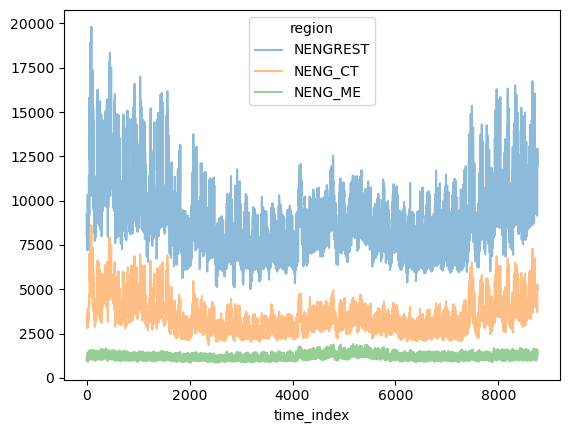

In [5]:
load_curves.plot(alpha=0.5)

## Load curve components

The individual components of a final load curve can also be accessed.

### Scaled load without electrified technologies


In [7]:
scaled_load = make_load_curves(pg_engine, scenario_settings[2030]["p1"])

### Profiles of electrified technologies

In [9]:
from powergenome.util import regions_to_keep


keep_regions, region_agg_map = regions_to_keep(
        settings["model_regions"], settings.get("region_aggregations", {}) or {}
    )

flex_profiles = electrification_profiles(
    settings.get("electrification_stock_fn"),
    settings["model_year"],
    settings.get("electrification_scenario"),
    keep_regions,
    settings.get("utc_offset", 0),
    settings.get("EFS_DATA"),
)

In [10]:
flex_profiles

,time_index,region,load_mw,resource
0,1,NENGREST,745.700398,res_space_heat_cool
1,1,NENG_CT,283.349089,res_space_heat_cool
2,1,NENG_ME,71.015940,res_space_heat_cool
3,2,NENGREST,821.574060,res_space_heat_cool
4,2,NENG_CT,312.722214,res_space_heat_cool
...,...,...,...,...
26275,8759,NENG_CT,0.011731,trans_bus
26276,8759,NENG_ME,0.067991,trans_bus
26277,8760,NENGREST,0.078501,trans_bus
26278,8760,NENG_CT,0.011260,trans_bus


### Distributed generation

In [11]:
dg_profiles = make_distributed_gen_profiles(pg_engine, scenario_settings[2030]["p1"])
dg_profiles

region,NENGREST,NENG_CT,NENG_ME
1,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000
...,...,...,...
8756,1418.149007,485.614952,70.705317
8757,150.894143,78.085928,0.000630
8758,0.000000,0.000000,0.000000
8759,0.000000,0.000000,0.000000
